# AlexNet


第一个典型的卷积神经网络是 LeNet5 ，但是第一个开启深度学习的网络却是 AlexNet，这个网络在2012年的ImageNet竞赛中取得冠军。这网络提出了深度学习常用的技术：ReLU和Dropout。AlexNet网络结构在整体上类似于LeNet，都是先卷积然后在全连接，但在细节上有很大不同，AlexNet更为复杂，Alexnet模型由5个卷积层和3个池化Pooling层，其中还有3个全连接层构成，共有$6 \times 10^7$个参数和65000个神经元，最终的输出层是1000通道的Softmax。AlexNet 跟 LeNet 结构类似，但使⽤了更多的卷积层和更⼤的参数空间来拟合⼤规模数据集 ImageNet，它是浅层神经⽹络和深度神经⽹络的分界线。


参考资料：
* [PyTorch 的 dropout使用](https://zhuanlan.zhihu.com/p/575456981)
* [ReLU激活函数](https://zhuanlan.zhihu.com/p/428448728)

AlexNet的网络架构如下图所示：
![AlexNet](images/fig-dl-alexnet-netarch-crop.jpg)

In [1]:
import torch.nn as nn
import torch
from torch.autograd import Variable

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):   
        super(AlexNet, self).__init__()
        self.features = nn.Sequential( 
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),       

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6, 4096),  #全链接
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) #展平或者view()
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #何教授方法
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                #正态分布赋值
                nn.init.normal_(m.weight, 0, 0.01) 
                nn.init.constant_(m.bias, 0)

In [2]:
test_x = torch.zeros(1, 3, 227, 227)
net = AlexNet()
test_y = net.features(test_x)
print(test_y.shape)
test_y = net(test_x)
print(test_y.shape)

torch.Size([1, 256, 6, 6])
torch.Size([1, 1000])


## CIFAR 10

首先介绍一个数据集 CIFAR10，后续以此数据集为例介绍各种卷积网络的结构。

CIFAR10 这个数据集一共有 50000 张训练集，10000 张测试集，两个数据集里面的图片都是 png 彩色图片，图片大小是 32 x 32 x 3，一共是 10 分类问题，分别为飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车。这个数据集是对网络性能测试一个非常重要的指标，可以说如果一个网络在这个数据集上超过另外一个网络，那么这个网络性能上一定要比另外一个网络好，目前这个数据集最好的结果是 95% 左右的测试集准确率。

![](images/CIFAR10.png)


CIFAR10 已经被 PyTorch 内置了，使用非常方便，只需要调用 `torchvision.datasets.CIFAR10` 就可以了

## 网络训练

使用CIFAR10数据集对网络进行训练。

In [4]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
from utils import train


# 数据转换
def data_tf(x):
    # Ref: https://www.cnblogs.com/dychen/p/14025356.html
    im_aug = tfs.Compose([
        tfs.Resize(227),
        tfs.ToTensor(),
        tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    x = im_aug(x)
    return x
     
train_set  = CIFAR10('../../data', train=True, transform=data_tf)
train_data = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set   = CIFAR10('../../data', train=False, transform=data_tf)
test_data  = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
net = AlexNet(num_classes=10)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

res = train(net, train_data, test_data, 20, optimizer, criterion, use_cuda=True)

[ 0] Train:(L=1.762618, Acc=0.345328), Valid:(L=1.479336, Acc=0.472310), T: 00:03:08
[ 1] Train:(L=1.424909, Acc=0.486453), Valid:(L=1.276258, Acc=0.542820), T: 00:03:08
[ 2] Train:(L=1.294979, Acc=0.536165), Valid:(L=1.224811, Acc=0.565170), T: 00:03:10
[ 3] Train:(L=1.211559, Acc=0.568754), Valid:(L=1.135080, Acc=0.597112), T: 00:03:10
[ 4] Train:(L=1.142591, Acc=0.596487), Valid:(L=1.088278, Acc=0.616792), T: 00:03:08
[ 5] Train:(L=1.087808, Acc=0.616488), Valid:(L=1.048046, Acc=0.625198), T: 00:03:12
[ 6] Train:(L=1.040570, Acc=0.631973), Valid:(L=1.092849, Acc=0.617880), T: 00:03:07
[ 7] Train:(L=0.999386, Acc=0.648338), Valid:(L=1.021422, Acc=0.641317), T: 00:03:10
[ 8] Train:(L=0.961721, Acc=0.661725), Valid:(L=1.038800, Acc=0.633703), T: 00:03:10
[ 9] Train:(L=0.932042, Acc=0.669577), Valid:(L=1.009300, Acc=0.640724), T: 00:03:11
[10] Train:(L=0.898817, Acc=0.682425), Valid:(L=0.966455, Acc=0.659118), T: 00:03:14
[11] Train:(L=0.867096, Acc=0.692415), Valid:(L=0.957053, Acc=0.6

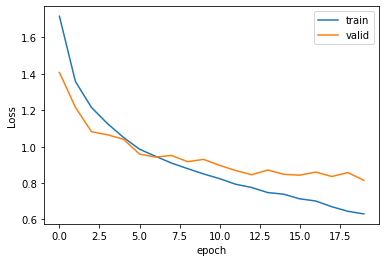

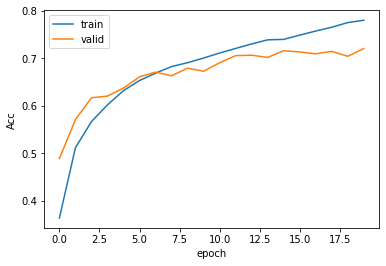

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(res[0], label='train')
plt.plot(res[2], label='valid')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.savefig('fig-res-alexnet-train-validate-loss.pdf')
plt.show()

plt.plot(res[1], label='train')
plt.plot(res[3], label='valid')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.legend(loc='best')
plt.savefig('fig-res-alexnet-train-validate-acc.pdf')
plt.show()

In [ ]:
# save raw data
import numpy
numpy.save('fig-res-alexnet_data.npy', res)